In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [122]:
df=pd.read_csv('./HINDUNILVR.csv',index_col='Date',parse_dates=True)

Data Pre processing


In [123]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HINDLEVER,EQ,2136.60,2300.0,2307.55,2300.00,2307.55,2307.55,2307.08,24903,5.745330e+12,NaN,NaN,NaN
2000-01-04,HINDLEVER,EQ,2307.55,2381.0,2381.00,2250.00,2270.00,2281.05,2298.15,58514,1.344740e+13,NaN,NaN,NaN
2000-01-05,HINDLEVER,EQ,2281.05,2200.0,2250.00,2105.00,2183.50,2199.90,2211.17,80296,1.775482e+13,NaN,NaN,NaN
2000-01-06,HINDLEVER,EQ,2199.90,2224.9,2360.00,2210.00,2300.00,2288.20,2301.80,190032,4.374157e+13,NaN,NaN,NaN
2000-01-07,HINDLEVER,EQ,2288.20,2300.0,2452.00,2282.25,2395.00,2412.95,2380.24,192582,4.583919e+13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HINDUNILVR,EQ,2307.75,2324.0,2369.80,2311.00,2367.70,2360.65,2340.89,1946867,4.557405e+14,85684.0,1289103.0,0.6621
2021-04-27,HINDUNILVR,EQ,2360.65,2363.0,2386.45,2352.95,2378.00,2379.85,2374.40,1668456,3.961583e+14,84641.0,1089882.0,0.6532
2021-04-28,HINDUNILVR,EQ,2379.85,2380.0,2445.00,2366.30,2404.00,2406.55,2414.15,1951215,4.710522e+14,84910.0,1024216.0,0.5249


In [124]:
df['Date']=df.index

In [125]:
start_date='2011-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [126]:
df=df.loc[mask]

In [127]:
df=df.loc[mask]

In [128]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [129]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [130]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [131]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [132]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (2427, 50) Y.shape (2427,)


In [133]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

ANN

In [134]:
i=Input(shape=(T,))
x=Dense(400,activation='relu')(i)
x=Dense(100,activation='relu')(x)
x=Dense(50,activation='relu')(x)
x=Dense(1,activation='relu')(x)
model_ann=Model(i,x)
model_ann.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_22 (Dense)            (None, 400)               20400     
                                                                 
 dense_23 (Dense)            (None, 100)               40100     
                                                                 
 dense_24 (Dense)            (None, 50)                5050      
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________


In [135]:
model_ann.compile(
    loss='mse',
    optimizer='adamax',
    metrics='mae'
)

In [136]:
r=model_ann.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
53/53 [==============================] - 1s 4ms/step - loss: 108.7243 - mae: 7.2516 - val_loss: 1000.0406 - val_mae: 20.4785
Epoch 2/100
53/53 [==============================] - 0s 2ms/step - loss: 105.9381 - mae: 7.1340 - val_loss: 1005.4406 - val_mae: 20.5247
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 104.3467 - mae: 7.0774 - val_loss: 1011.3439 - val_mae: 20.6342
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: 101.8462 - mae: 6.9734 - val_loss: 1017.2621 - val_mae: 20.6890
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 99.9866 - mae: 6.9097 - val_loss: 1020.2335 - val_mae: 20.7492
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 97.4768 - mae: 6.8082 - val_loss: 1027.0310 - val_mae: 20.9517
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 95.0421 - mae: 6.7089 - val_loss: 1045.0488 - val_mae: 21.3968
Epoch 8/100
53/53 [=========================

CNN

In [137]:
i=Input(shape=(T,1))
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1)(x)
model_cnn=Model(i,x)
model_cnn.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 48, 25)            100       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_6 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_26 (Dense)            (None, 1)                 51  

In [138]:
model_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [139]:
r=model_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
53/53 [==============================] - 1s 7ms/step - loss: 114.1597 - mae: 7.4996 - mse: 114.1597 - val_loss: 1053.3695 - val_mae: 20.8472 - val_mse: 1053.3695
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 109.7180 - mae: 7.3476 - mse: 109.7180 - val_loss: 1058.6038 - val_mae: 20.4506 - val_mse: 1058.6038
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 109.0716 - mae: 7.3187 - mse: 109.0716 - val_loss: 1056.5281 - val_mae: 20.4382 - val_mse: 1056.5281
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 109.0671 - mae: 7.3058 - mse: 109.0671 - val_loss: 1051.6277 - val_mae: 20.4494 - val_mse: 1051.6277
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 108.3285 - mae: 7.2914 - mse: 108.3285 - val_loss: 1043.9972 - val_mae: 20.4600 - val_mse: 1043.9972
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 107.9326 - mae: 7.2603 - mse: 107.9326 - val_loss: 1034.6

LSTM

In [140]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm=Model(i,x)
model_lstm.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 200)           161600    
                                                                 
 lstm_5 (LSTM)               (None, 50, 200)           320800    
                                                                 
 global_max_pooling1d_7 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_27 (Dense)            (None, 100)               20100     
                                                                 
 dense_28 (Dense)            (None, 50)                5050      
                                                          

In [141]:
check_point_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [142]:
model_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [143]:
r=model_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm]
)

Epoch 1/100
53/53 [==============================] - 12s 179ms/step - loss: 108.8294 - mae: 7.2707 - mse: 108.8294 - val_loss: 1001.2794 - val_mae: 20.4415 - val_mse: 1001.2794
Epoch 2/100
53/53 [==============================] - 9s 166ms/step - loss: 108.6666 - mae: 7.2827 - mse: 108.6666 - val_loss: 1002.6354 - val_mae: 20.4068 - val_mse: 1002.6354
Epoch 3/100
53/53 [==============================] - 9s 166ms/step - loss: 108.5599 - mae: 7.2564 - mse: 108.5599 - val_loss: 1002.2095 - val_mae: 20.4096 - val_mse: 1002.2095
Epoch 4/100
53/53 [==============================] - 9s 165ms/step - loss: 108.6009 - mae: 7.2648 - mse: 108.6009 - val_loss: 1002.4240 - val_mae: 20.4063 - val_mse: 1002.4240
Epoch 5/100
53/53 [==============================] - 9s 167ms/step - loss: 108.4659 - mae: 7.2578 - mse: 108.4659 - val_loss: 1001.9645 - val_mae: 20.4125 - val_mse: 1001.9645
Epoch 6/100
53/53 [==============================] - 9s 168ms/step - loss: 108.5610 - mae: 7.2654 - mse: 108.5610 - val

GRU

In [144]:
i=Input(shape=(T,1))
x=GRU(200,return_sequences=True)(i)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_gru=Model(i,x)
model_gru.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe98c155110>>

In [145]:
check_point_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [146]:
model_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [147]:
r=model_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_gru]
)

Epoch 1/100
53/53 [==============================] - 12s 165ms/step - loss: 109.2147 - mae: 7.2886 - mse: 109.2147 - val_loss: 1002.2573 - val_mae: 20.4769 - val_mse: 1002.2573
Epoch 2/100
53/53 [==============================] - 8s 151ms/step - loss: 108.7996 - mae: 7.2800 - mse: 108.7996 - val_loss: 1003.1807 - val_mae: 20.3967 - val_mse: 1003.1807
Epoch 3/100
53/53 [==============================] - 8s 150ms/step - loss: 108.5548 - mae: 7.2670 - mse: 108.5548 - val_loss: 1004.2828 - val_mae: 20.3977 - val_mse: 1004.2828
Epoch 4/100
53/53 [==============================] - 8s 149ms/step - loss: 108.8694 - mae: 7.2700 - mse: 108.8694 - val_loss: 1005.3485 - val_mae: 20.4063 - val_mse: 1005.3485
Epoch 5/100
53/53 [==============================] - 8s 151ms/step - loss: 108.5750 - mae: 7.2782 - mse: 108.5750 - val_loss: 1003.1615 - val_mae: 20.3998 - val_mse: 1003.1615
Epoch 6/100
53/53 [==============================] - 8s 150ms/step - loss: 108.6187 - mae: 7.2654 - mse: 108.6187 - val

Predictions

In [148]:
train_idx[:T+1]=False

In [149]:
Ptrain_ann=model_ann.predict(Xtrain).flatten()
Ptest_ann=model_ann.predict(Xtest).flatten()


In [150]:
Ptrain_cnn=model_cnn.predict(Xtrain).flatten()
Ptest_cnn=model_cnn.predict(Xtest).flatten()

In [151]:
Ptrain_lstm=model_lstm.predict(Xtrain).flatten()
Ptest_lstm=model_lstm.predict(Xtest).flatten()

In [152]:
Ptrain_gru=model_gru.predict(Xtrain).flatten()
Ptest_gru=model_gru.predict(Xtest).flatten()

In [153]:
df.loc[train_idx,'Diff ANN train prediction']=Ptrain_ann
df.loc[test_idx,'Diff ANN test prediction']=Ptest_ann

In [154]:
df.loc[train_idx,'Diff CNN train prediction']=Ptrain_cnn
df.loc[test_idx,'Diff CNN test prediction']=Ptest_cnn

In [155]:
df.loc[train_idx,'Diff LSTM train prediction']=Ptrain_lstm
df.loc[test_idx,'Diff LSTM test prediction']=Ptest_lstm

In [156]:
df.loc[train_idx,'Diff GRU train prediction']=Ptrain_gru
df.loc[test_idx,'Diff GRU test prediction']=Ptest_gru

In [157]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [158]:
last_train=train.iloc[-1]['Prev Close']

In [159]:
df.loc[train_idx,'train_ANN']=prev[train_idx]+Ptrain_ann
df.loc[test_idx,'Prediction_ANN']=prev[test_idx]+Ptest_ann

In [160]:
df.loc[train_idx,'train_CNN']=prev[train_idx]+Ptrain_cnn
df.loc[test_idx,'Prediction_CNN']=prev[test_idx]+Ptest_cnn

In [161]:
df.loc[train_idx,'train_LSTM']=prev[train_idx]+Ptrain_lstm
df.loc[test_idx,'Prediction_LSTM']=prev[test_idx]+Ptest_lstm

In [162]:
df.loc[train_idx,'train_GRU']=prev[train_idx]+Ptrain_gru
df.loc[test_idx,'Prediction_GRU']=prev[test_idx]+Ptest_gru

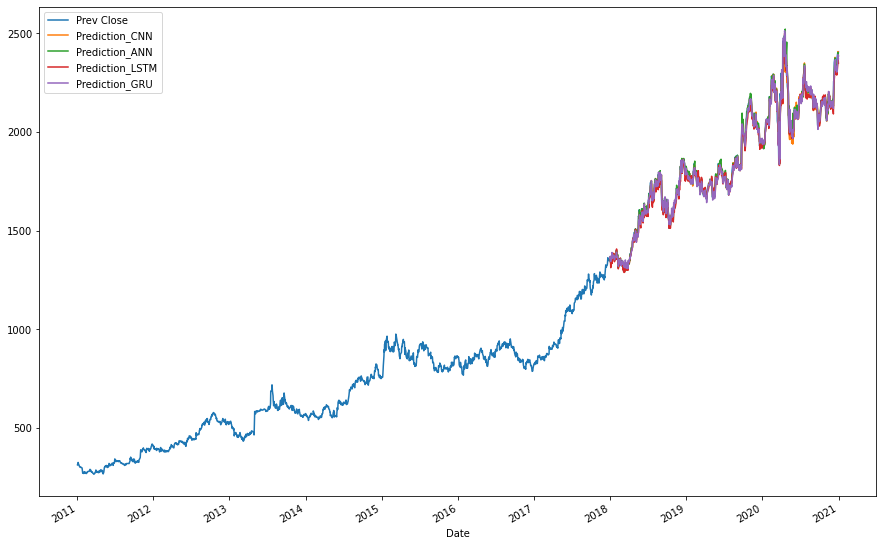

In [163]:
df[[ 'Prev Close','Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10));

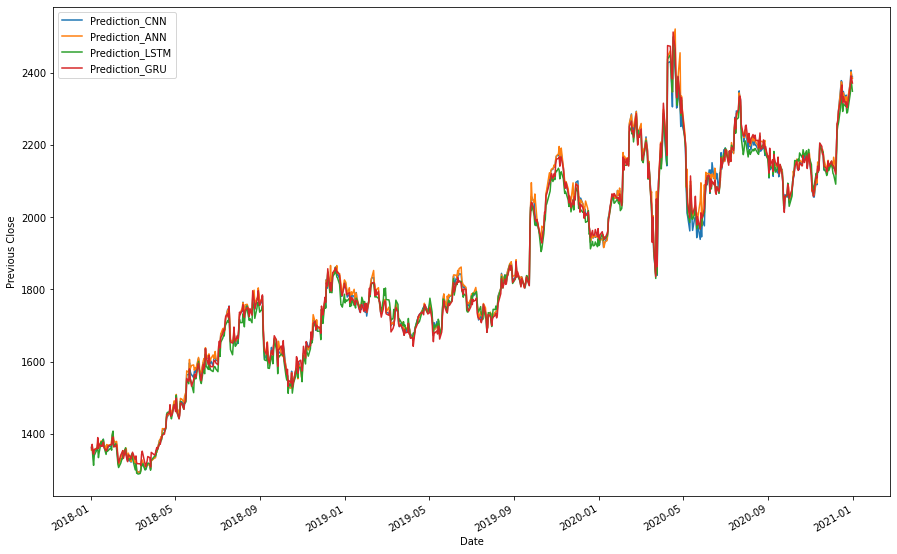

In [164]:
df[[ 'Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10),
    ylabel=("Previous Close"));

Evaluation

In [165]:
pred_ann=df['Prediction_ANN']
pred_ann.dropna(inplace=True)

In [166]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_ann))
print(rmse)

33.732187275035706


In [167]:
error=mean_absolute_error(test['Prev Close'],pred_ann)
print(error)

22.030646843824172


In [168]:
r2_score(test['Prev Close'],pred_ann)

0.985487393282138

In [169]:
pred_cnn=df['Prediction_CNN']
pred_cnn.dropna(inplace=True)

In [170]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_cnn))
print(rmse)

32.62884398804393


In [171]:
error=mean_absolute_error(test['Prev Close'],pred_cnn)
print(error)

20.9732270512805


In [172]:
r2_score(test['Prev Close'],pred_cnn)

0.9864212499072609

In [173]:
pred_lstm=df['Prediction_LSTM']
pred_lstm.dropna(inplace=True)

In [174]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm))
print(rmse)

36.14961535137926


In [175]:
error=mean_absolute_error(test['Prev Close'],pred_lstm)
print(error)

25.182098196983375


In [176]:
r2_score(test['Prev Close'],pred_lstm)

0.983332756439141

In [177]:
pred_gru=df['Prediction_GRU']
pred_gru.dropna(inplace=True)

In [178]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_gru))
print(rmse)

33.854197831154075


In [179]:
error=mean_absolute_error(test['Prev Close'],pred_gru)
print(error)

23.26073071181493


In [180]:
r2_score(test['Prev Close'],pred_gru)

0.985382218154929